In [ ]:
# RG flow, iterative estimation, Graph neural network
# these are all similar : 1) blur, 2) cutoff eigenvalue, 3) sharpen, until it is consistent (fixed point)

In [157]:
import pandas as pd 
import numpy as np 

In [158]:
x = pd.read_csv("close.csv", index_col=0, parse_dates=True)
x = np.log(x).diff().iloc[1:]

In [160]:
# sort using 3 leading factors
covmat = np.cov(x.T)
eigvec = np.linalg.eigh(covmat).eigenvectors[:, -1:-4:-1]
x = x.values[:, np.argsort(eigvec@[100,1,0.01])]

In [161]:
covmat = np.cov(x.T)

# decay parameter
lamb = 0.1

# diffusion kernel # (1-lA)^-1 = (1+lA+l^2A^2+...)
def inv_cut(x):
    eigv, eigvec = np.linalg.eigh(x)
    return sum(evector[:,np.newaxis]@evector[np.newaxis,:]/evalue for evalue, evector in zip(eigv, eigvec.T) if np.abs(evalue) > 1e-6)
kernel = inv_cut(1 - lamb * covmat)
kernel /= np.linalg.trace(kernel)
diffuse = lambda x: 0.5 * ((kernel @ x) + (kernel @ x).T)

# drop small eigenvalues 
def cutoff(x):
    eigv, eigvec = np.linalg.eigh(x)
    return sum(\
        evector[:,np.newaxis]@evector[np.newaxis,:]/evalue for i, (evalue, evector) \
            in enumerate(reversed(list(zip(eigv, eigvec.T)))) \
                if (np.abs(evalue) > 1e-6) and (i<0.5 * x.shape[0])
                )

# loop
repeat = lambda f,x,n : repeat(f,f(x),n-1) if n>0 else f(x)


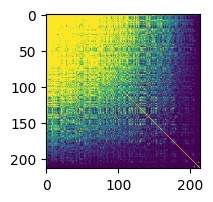

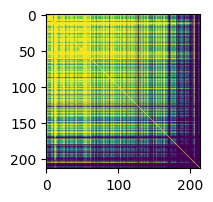

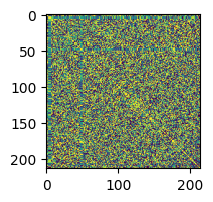

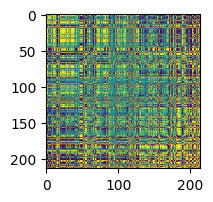

In [162]:
import matplotlib.pyplot as plt 
def show(x): 
    plt.figure(figsize=(2,2)); plt.imshow( np.clip(x, np.quantile(x,0.2), np.quantile(x,0.8))); plt.show()
show(covmat)
show(diffuse(covmat))
show(cutoff(diffuse(covmat)))
show(repeat(lambda x:cutoff(diffuse(x)), covmat,1000))

In [163]:
fixed_point = repeat(lambda x:cutoff(diffuse(x)), covmat,1000)

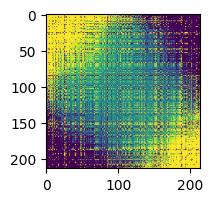

In [164]:
# sort using 3 leading factors
eigvec = np.linalg.eigh(fixed_point).eigenvectors[:, -1:-4:-1]
mapping = np.argsort(eigvec@[100,1,0.01])
fixed_point = fixed_point[mapping][:, mapping]
show(fixed_point)

<BarContainer object of 214 artists>

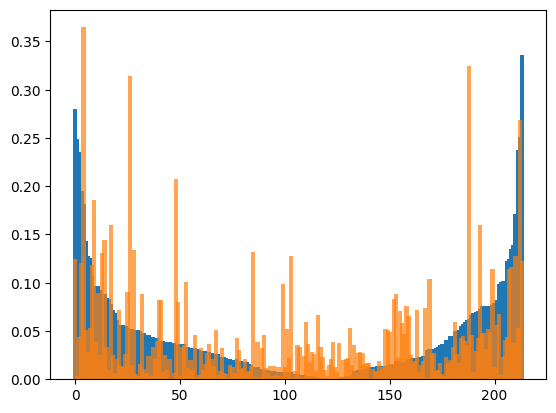

In [172]:
plt.bar(
    np.arange(0,fixed_point.shape[0]), 
    np.abs(np.linalg.eigh(fixed_point).eigenvectors[:,-1]),
    width=2
    )
plt.bar(
    np.arange(0,fixed_point.shape[0]), 
    np.abs(np.linalg.eigh(fixed_point).eigenvectors[:,-2]),
    width=2, alpha=0.7
    )